# Exploratory Analysis: Returning Users

Returning Users:
1. Returning Reviews Distribution
2. Difference on Product Ratings
3. Difference on Product Nutrients
4. Difference on Length of Review
5. Difference on Words Used
6. Difference on Time of Review
    + Using heatmap to show by 30 days or by week

TODO:
+ on helpful reviews, do returning users given different "helpfullness"?
+ model returning users by past reviews
  + i.e. given a review, is this user likely to review again?
+ headling difference, e.g. length, word...etc 
  + is the difference correlated with anything?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import os
import json
from sqlalchemy import create_engine

from dotenv import load_dotenv # env variables
load_dotenv(verbose=True)

True

In [3]:
SQLALCHEMY_DATABASE_URI = os.getenv('DATABASE_URL')
engine = create_engine(SQLALCHEMY_DATABASE_URI)

## 1. Returning Users Distribution

In [8]:
sql = \
"""
SELECT 
    review_id, customer_id
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))
df.shape

(115341, 3)

In [9]:
# about 80% only reviews once, 20% reviews more 
print(df[df.review_times > 1].shape[0])
print(df.shape[0])
df[df.review_times > 1].shape[0] / df.shape[0]

23765
115341


0.20604121691332658

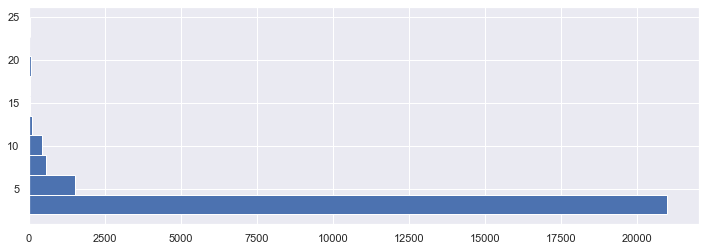

In [10]:
plt.figure(figsize=(12, 4))
# plot excluding only review once
plt.hist(df[df.review_times > 1].review_times, orientation='horizontal')
plt.show()

## 2. Difference on _Product Ratings_

In [12]:
sql = \
"""
SELECT 
    review_id, customer_id, star_rating
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
df.shape

(115341, 5)

In [13]:
df.binary.value_counts()

once    91576
more    23765
Name: binary, dtype: int64

In [15]:
df[df.binary =='once'].star_rating.describe()
# note mean is lower, 25% quantile at 4

count    91576.000000
mean         4.389425
std          1.166922
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: star_rating, dtype: float64

In [16]:
df[df.binary =='more'].star_rating.describe()
# 25% quantile at 5

count    23765.000000
mean         4.543362
std          0.958413
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: star_rating, dtype: float64

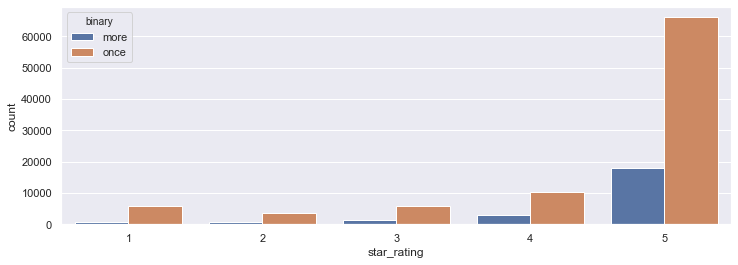

In [18]:
plt.figure(figsize=(12, 4))
df.pipe((sns.countplot, 'data'), x='star_rating', hue='binary')
plt.show()
# count plot with counts
# note mroe group is more group is almost non-observable at rating 1 to 2

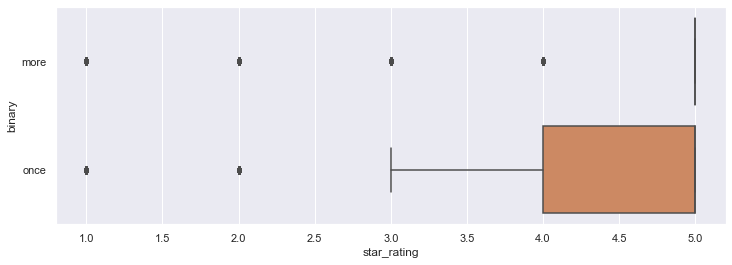

In [19]:
plt.figure(figsize=(12, 4))
df.pipe((sns.boxplot, 'data'), x='star_rating', y='binary')
# plt.savefig('./figures/return_rating-box.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

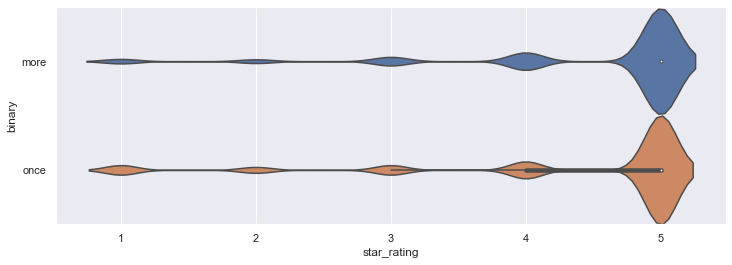

In [20]:
plt.figure(figsize=(12, 4))
df.pipe((sns.violinplot, 'data'), x='star_rating', y='binary', scale='area', width=1.)
# plt.savefig('./figures/return_rating-violin.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

## 3. Difference on Product Nutrients

In [21]:
sql = \
"""
SELECT 
    review_id, customer_id, 
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
df.shape

(115341, 12)

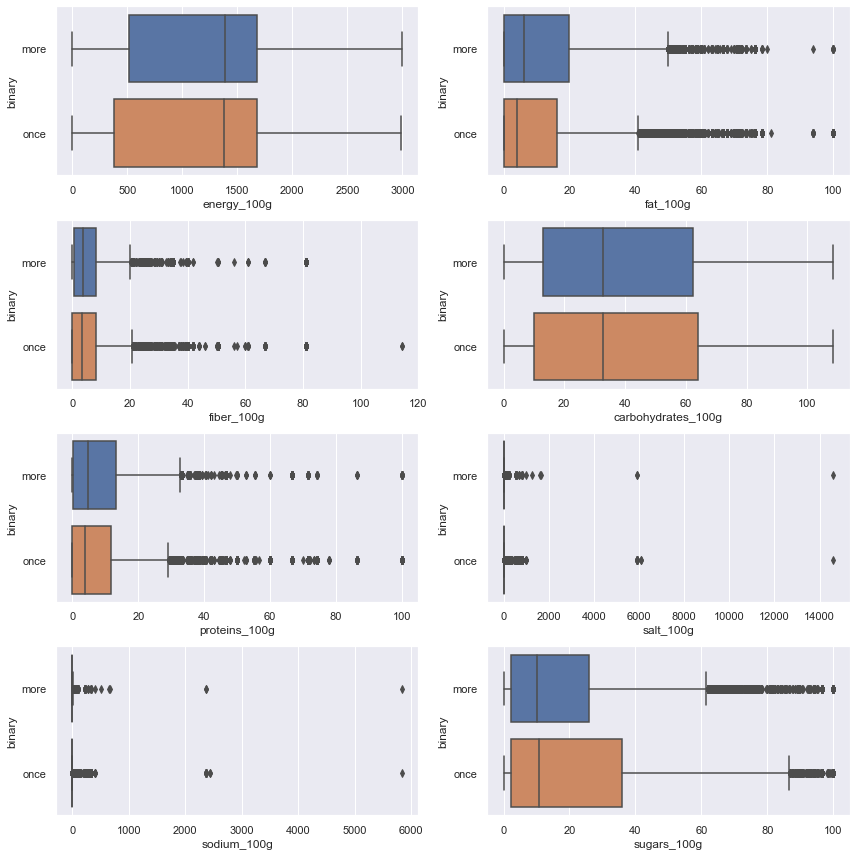

In [22]:
nutrients = ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 
             'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

fig, axs = plt.subplots(4,2, figsize=(12, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(8):
    sns.boxplot(x=nutrients[i], y='binary', data=df, ax=axs[i])
plt.tight_layout()
# plt.savefig('./figures/return_nutrients.png', bbox_inches='tight', dpi=300)
plt.show()
# only some difference in sugar content

### Examine the Sugar Content

In [28]:
sql = \
"""
SELECT 
    review_id, customer_id, 
    main_category_en, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
df.shape

(115341, 6)

In [31]:
df.main_category_en.notna().sum() / df.shape[0]
# percentage of data having category data

0.41879297040948144

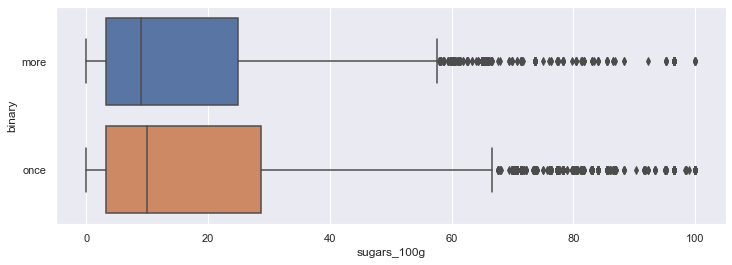

In [34]:
plt.figure(figsize=(12, 4))
df[df.main_category_en.notna()]\
    .pipe((sns.boxplot, 'data'), x='sugars_100g', y='binary', order=['more', 'once'])
plt.show()
# data having category value, compare between more and once

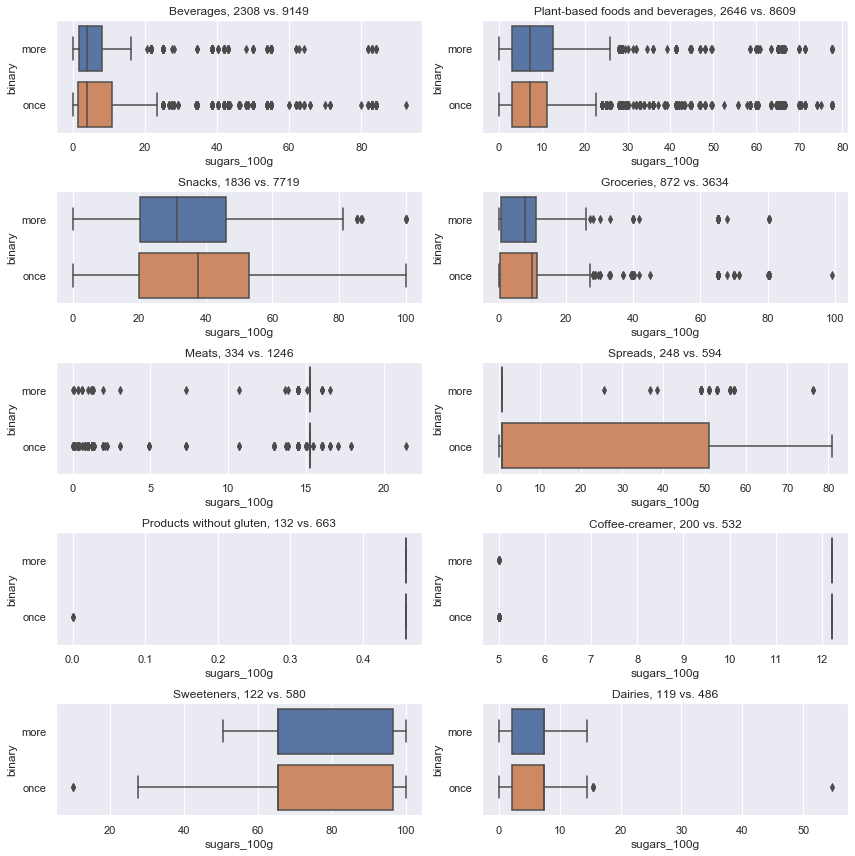

In [99]:
# get top10 product category
top10 = df[df.main_category_en.notna()].main_category_en.value_counts().head(10).index
# plot by each category
fig, axs = plt.subplots(5,2, figsize=(12, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(10):
    tmp = df[df.main_category_en == top10[i]]
    moreCounts = tmp[tmp.binary == 'more'].shape[0]
    onceCounts = tmp[tmp.binary == 'once'].shape[0]
    axs[i].title.set_text(top10[i] + ', ' + str(moreCounts) + ' vs. ' + str(onceCounts))
    sns.boxplot(x='sugars_100g', y='binary', data=tmp, ax=axs[i], order=['more', 'once'])
    
plt.tight_layout()
# plt.savefig('./figures/return_sugars_category.png', bbox_inches='tight', dpi=300)
plt.show()

boxplot with plotly
```python
import plotly.io as pio
spreads = df[df.main_category_en == 'Spreads']
clrs = px.colors.qualitative.Set3
# each trace has its own color
traces = []
for idx, group in enumerate(['once', 'more']):
    tmp = {'type': 'box', 
           'x': spreads[spreads.binary == group].sugars_100g,
           'name': str(group),
           'opacity': 1,
           'fillcolor': clrs[idx], # box filling color
           'line': {'color': 'black'}, # box border color
          }
    traces.append(tmp)
# len(traces)
layouts = {'xaxis': {'title': 'Months'}, 
           'yaxis': {'title': 'energy_100g'},
           'margin': {'l': 20, 'r': 20, 't': 50, 'b': 20},
           'width': 800, 'height': 400}

pio.show({'data': traces, 'layout': layouts})
```

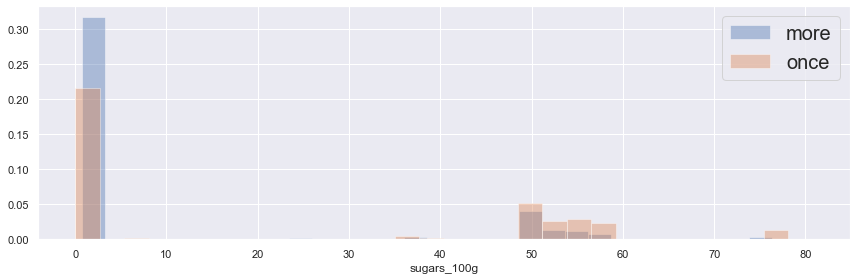

In [125]:
spreads = df[df.main_category_en == 'Spreads']

plt.figure(figsize=(12, 4))
sns.distplot(spreads[spreads.binary == 'more'].sugars_100g, kde=False, bins=30, norm_hist=True)
sns.distplot(spreads[spreads.binary == 'once'].sugars_100g, kde=False, bins=30, norm_hist=True)
plt.legend(['more', 'once'], prop={'size': 20})
plt.tight_layout()
# plt.savefig('./figures/return_sugars_spreads.png', bbox_inches='tight', dpi=300)
plt.show()

## 4. Difference on Review Length

In [22]:
func = lambda s:  0 if s is None else len(s.split(' '))
tmp = df.assign(review_len=lambda df: df.review_body.apply(func))

tmp.review_len.describe()

count    115341.000000
mean         36.733148
std          44.651252
min           0.000000
25%          11.000000
50%          25.000000
75%          45.000000
max        1439.000000
Name: review_len, dtype: float64

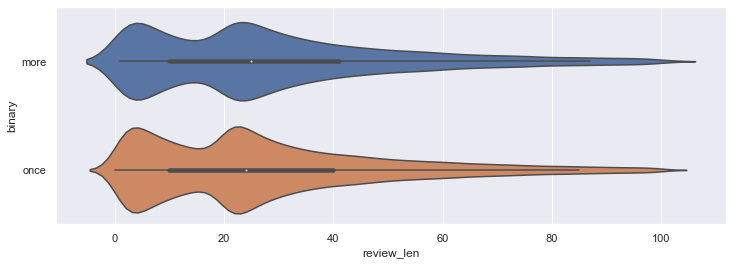

In [24]:
# having outliers, set a limit by 100
plt.figure(figsize=(12, 4))

tmp.query('review_len <= 100')\
    .pipe((sns.violinplot, 'data'), x='review_len', y='binary')
# plt.savefig('./figures/return_review-length.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

## 5. Difference on Words used in Reviews
+ https://www.datacamp.com/community/tutorials/wordcloud-python
+ https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911
+ to Lollipop Chart

In [25]:
import re
import json
from collections import Counter
from nltk.corpus import stopwords
# from nltk.tokenize import TweetTokenizer

In [26]:
sql = \
"""
SELECT 
    review_id, customer_id, review_body
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
df.shape

(115341, 5)

In [27]:
stopWords = set(stopwords.words('english')) # 179 originally
commonWords = ["br"]
stopWords.update(commonWords)
# stopWords
len(stopWords)

180

In [28]:
# build review strings by each group
text_once = []
text_more = []
for row in df.itertuples():
    if (row.binary == 'once') & (row.review_body is not None):
        for word in re.split(r'\W+', row.review_body.lower()):
            if (word not in stopWords) & (word != ""): 
                text_once.append(word)
    elif (row.binary == 'more') & (row.review_body is not None):
        for word in re.split(r'\W+', row.review_body.lower()):
            if (word not in stopWords) & (word != ""): 
                text_more.append(word)
                
counterOnce = Counter(text_once)
counterMore = Counter(text_more)
len(text_once), len(text_more)

(1639462, 469124)

Sorted by Percentage, ascending
```python
sorted([(c, counterOnce[c] / len(text_once) * 100.0) for c in counterOnce], 
       key=lambda d: d[1], reverse=True)[:10]

sorted([(c, counterMore[c] / len(text_more) * 100.0) for c in counterMore], 
       key=lambda d: d[1], reverse=True)[:10]
```

return json as:   
`{'more':[{word: , value: }], 'once': [{word: , value: }]}`

In [42]:
# if output the percentage of a token
pctOnce = sorted([(c, counterOnce[c] / len(text_once) * 100.0) for c in counterOnce], 
                 key=lambda d: d[1], reverse=True)
pctMore = sorted([(c, counterMore[c] / len(text_more) * 100.0) for c in counterMore], 
                 key=lambda d: d[1], reverse=True)

d = {'once': [{'word': w, 'value': v} for (w, v) in pctOnce], 
     'more': [{'word': w, 'value': v} for (w, v) in pctMore] }

```python
# if output the count of a token 
d = {'once': [{'word': w, 'value': v} for (w, v) in counterOnce.items()], 
     'more': [{'word': w, 'value': v} for (w, v) in counterMore.items()] }
```

In [43]:
# reduce size to 5000
d['once'] = d['once'][:5000]
d['more'] = d['more'][:5000]

In [44]:
#dump as a long string
# json.dumps(d)

# dump to a file
# as objects in file
with open('returning_words.json', 'w', encoding='utf-8') as f:
    json.dump(d, f, ensure_ascii=False, indent=4)

## 6. Difference on Time of Review
+ For heatmap
+ Count by different group users vs. weekday/monthday
+ [`pd.Grouper`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
   

In [4]:
import calendar

In [5]:
start_date = '2014-01-01'
end_date = '2014-12-31'

In [6]:
query = \
"""
SELECT 
    customer_id, review_id, review_date
FROM 
    food_reviews
WHERE 
    verified_purchase LIKE 'Y'
    AND review_date IS NOT NULL
    AND review_date BETWEEN '{0}' AND '{1}'
ORDER BY
    review_date
""".format(start_date, end_date)
df = pd.read_sql(query, con=engine)\
    .assign(review_times=lambda d: d.groupby('customer_id')[['review_id']].transform('count'))
df.shape

(38254, 4)

In [7]:
n_groups = 3
# n groups + weekday
# compute percentage by each group index, i.e. groupby(level=1)
df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.weekday, 'group'])[['review_id']].count()\
    .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))\
    .reset_index()\
    .replace(to_replace={'review_date': dict(zip(range(7), calendar.day_name))})\
    .rename(mapper={'review_id': 'percentage'}, axis=1)\
    .astype({'group': 'category'})\
    .head()\
    .to_json(orient ='records')

'[{"review_date":"Monday","group":1,"percentage":15.4406273338},{"review_date":"Monday","group":2,"percentage":15.7455931396},{"review_date":"Monday","group":3,"percentage":15.625},{"review_date":"Tuesday","group":1,"percentage":15.0983320886},{"review_date":"Tuesday","group":2,"percentage":15.0071462601}]'

In [8]:
n_groups = 3
# n groups + monthday
df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.day, 'group'])[['review_id']].count()\
    .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))\
    .reset_index()\
    .rename(mapper={'review_id': 'percentage'}, axis=1)\
    .astype({'group': 'category'})\
    .head()\
    .to_json(orient ='records')

'[{"review_date":1,"group":1,"percentage":3.0433159074},{"review_date":1,"group":2,"percentage":3.001429252},{"review_date":1,"group":3,"percentage":1.9270833333},{"review_date":2,"group":1,"percentage":3.1553398058},{"review_date":2,"group":2,"percentage":3.3349213911}]'

```python
n_groups = 3
grouper = 'weekday' # monthday

if grouper == 'weekday':
    data = \
    df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.weekday, 'group'])[['review_id']].count()
#     .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))
if grouper == 'monthday':
    data = \
    df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.day, 'group'])[['review_id']].count()
#     .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))

data.reset_index()\
    .rename(mapper={'review_id': 'percentage'}, axis=1)\
    .astype({'group': 'category'})\
    .to_json('returning_heatmap.json', orient ='records')
```

In [9]:
d = {}
# data from 2 groups to 5 groups
for n_groups in range(2, 6): 
    d1 = \
    df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.weekday, 'group'])[['review_id']].count()\
    .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))\
    .rename(index=dict(zip(range(7), range(1, 8))), level=0)\
    .reset_index()\
    .rename(mapper={'review_id': 'percentage'}, axis=1)\
    .astype({'group': 'category'})

    d2 = \
    df.assign(group=lambda df: df.review_times.apply(lambda d: (n_groups) if d >= (n_groups) else d))\
    .groupby([df.review_date.dt.day, 'group'])[['review_id']].count()\
    .groupby(level=1).apply(lambda d: 100 * ( d / d.sum()))\
    .reset_index()\
    .rename(mapper={'review_id': 'percentage'}, axis=1)\
    .astype({'group': 'category'})
    
    # export data
    d[n_groups] =  {'weekday': d1.to_dict(orient ='records'), 
                    'monthday': d2.to_dict(orient ='records')}

In [13]:
with open('returning_heatmap.json', 'w', encoding='utf-8') as f:
    json.dump(d, f, ensure_ascii=False, indent=4, )